In [1]:
# Impor library pandas
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Impor file csv data latih
transform_latih = pd.read_csv('./data_latih_clean.csv')
# Impor file dataset WHO Stunting dan Wasting
who_stunting = pd.read_csv('./dataset-who-stunting.csv', sep = ';', decimal = ',')
who_wasting = pd.read_csv('./dataset-who-wasting.csv', sep = ';', decimal = ',')

In [3]:
# Ubah label jenisKelamin menjadi string nominal (0 dan 1)
transform_latih['jenisKelamin'] = transform_latih['jenisKelamin'].str.replace('Male', '0')
transform_latih['jenisKelamin'] = transform_latih['jenisKelamin'].str.replace('Female', '1')

# Ubah string menjadi numeral
transform_latih['jenisKelamin'] = pd.to_numeric(transform_latih['jenisKelamin'])

In [4]:
# Buat kolom baru untuk label stunting dan wasting
transform_latih['statusStunting'] = 'Unknown'
transform_latih['statusWasting'] = 'Unknown'

In [5]:
# Ubah nilai Gender pada dataset WHO stunting
who_stunting['Gender'] = who_stunting['Gender'].str.replace('Female', '1')
who_stunting['Gender'] = who_stunting['Gender'].str.replace('Male', '0')

# Format nilai Gender menjadi numeral
who_stunting['Gender'] = pd.to_numeric(who_stunting['Gender'])

In [6]:
# Ubah nilai Gender pada dataset WHO wasting
who_wasting['Gender'] = who_wasting['Gender'].str.replace('Female', '1')
who_wasting['Gender'] = who_wasting['Gender'].str.replace('Male', '0')

# Format nilai Gender menjadi numeral
who_wasting['Gender'] = pd.to_numeric(who_wasting['Gender'])

In [7]:
# Tentukan nilai statusStunting pada dataset latih
# Loop seluruh data pada dataset untuk mencari zscore dan mengubah statusStunting
for cursor_latih in transform_latih.itertuples():
    # Cari data LMS yang sesuai dengan data cursor_latih
    cursor_who = who_stunting.loc[(who_stunting.Month == cursor_latih.umur) & (who_stunting.Gender == cursor_latih.jenisKelamin)]
    # Kalkulasi nilai z-score stunting
    zscore = (((cursor_latih.tinggiBadan / cursor_who.M)**cursor_who.L)-1) / (cursor_who.L * cursor_who.S)
    # Ubah data statusStunting
    if zscore.item() < (-2):
        transform_latih.loc[transform_latih.index == cursor_latih.Index, 'statusStunting'] = 1
    else:
        transform_latih.loc[transform_latih.index == cursor_latih.Index, 'statusStunting'] = 0

In [8]:
# Membuat dataframe baru untuk data istimewa
# istimewa disini yakni data yang tidak berkelipatan 0.5 pada dataset who-Wasting
data_istimewa = transform_latih.loc[transform_latih.tinggiBadan % 0.5 != 0, ['jenisKelamin', 'tinggiBadan']]

# Hapus duplikat pada iregular
data_istimewa.drop_duplicates(inplace=True)

In [9]:
# Menyesuaikan nama kolom
data_istimewa.rename(columns ={'jenisKelamin' : 'Gender', 'tinggiBadan' : 'Length'}, inplace=True)

# Menggabungkan data pada dataframe istimewa dan dataframe WHO Weight-for-Height
new_who_wasting = pd.concat([who_wasting, data_istimewa])

In [10]:
# Sortir data menurut Length
new_who_wasting.sort_values(by = ['Gender', 'Length'], inplace = True)

# Reset Index
new_who_wasting.reset_index(drop = True, inplace = True)

In [11]:
# Menerapkan interpolasi kedalam dataframe
# limit_area=inside untuk mengubah hanya data istimewa saja
new_who_wasting.interpolate(limit_area = 'inside', inplace=True)

In [12]:
# Tentukan nilai statusWasting pada dataset latih
# Loop seluruh data pada dataset untuk mencari zscore dan mengubah statusWasting
for cursor_latih in transform_latih.itertuples():
    # Cari data LMS yang sesuai dengan data cursor_latih
    cursor_who = new_who_wasting.loc[(new_who_wasting.Length == cursor_latih.tinggiBadan) & (new_who_wasting.Gender == cursor_latih.jenisKelamin)]
    # Kalkulasi nilai z-score stunting
    zscore = (((cursor_latih.beratBadan / cursor_who.M)**cursor_who.L)-1) / (cursor_who.L * cursor_who.S)
    # Ubah data statusStunting
    if zscore.item() < (-2):
        transform_latih.loc[transform_latih.index == cursor_latih.Index, 'statusWasting'] = 1
    else:
        transform_latih.loc[transform_latih.index == cursor_latih.Index, 'statusWasting'] = 0

In [13]:
# Ubah format statusStunting dan statusWasting menjadi numeral
transform_latih.statusStunting = pd.to_numeric(transform_latih.statusStunting) 
transform_latih.statusWasting = pd.to_numeric(transform_latih.statusWasting)

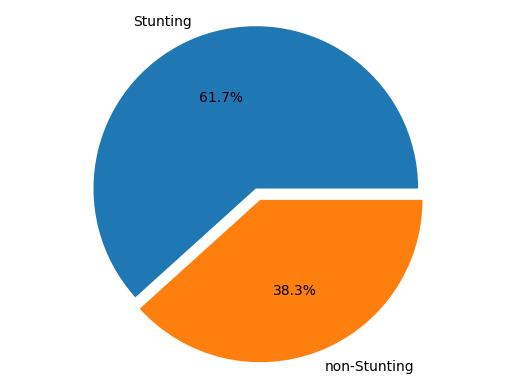

In [14]:
# Visualisasikan Data statusStunting
stunting = transform_latih.loc[transform_latih.statusStunting == 1, 'statusStunting'].count()
non_stunting = transform_latih.loc[transform_latih.statusStunting == 0, 'statusStunting'].count()

data = [stunting, non_stunting]
labels = ['Stunting', 'non-Stunting']
explode = [0.0, 0.075]

fig, ax = plt.subplots()
ax.pie(data, explode = explode, labels = labels, autopct = '%.1f%%')
ax.axis('equal')

plt.show()

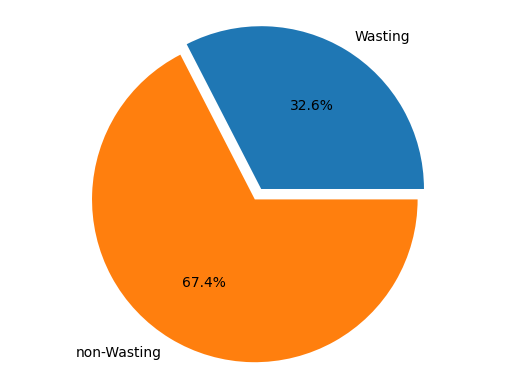

In [15]:
# Visualisasikan Data statusWasting
wasting = transform_latih.loc[transform_latih.statusWasting == 1, 'statusWasting'].count()
non_wasting = transform_latih.loc[transform_latih.statusWasting == 0, 'statusWasting'].count()

data = [wasting, non_wasting]
labels = ['Wasting', 'non-Wasting']
explode = [0.0, 0.075]

fig, ax = plt.subplots()
ax.pie(data, explode = explode, labels = labels, autopct = '%.1f%%')
ax.axis('equal')

plt.show()

In [16]:
# Membuat kolom keduanya atau sehat
transform_latih['statusKeduanya'] = 'Unknown'
transform_latih['statusSehat'] = 'Unknown'

# Tentukan nilai data pada label statusKeduanya dan statusSehat
for cursor_latih in transform_latih.itertuples():
    # Cek status keduanya dan ubah menjadi string angka 1, bukan integer
    if cursor_latih.statusStunting == 1:
        if cursor_latih.statusWasting == 1:
            transform_latih.loc[transform_latih.index == cursor_latih.Index, 'statusKeduanya'] = '1'
            continue
    elif cursor_latih.statusStunting == 0:
        if cursor_latih.statusWasting == 0:
            transform_latih.loc[transform_latih.index == cursor_latih.Index, 'statusSehat'] = '1'
            continue
            

# Setelah selesai mengecek dan merubah status keduanya dan sehat
# Ganti kata Unknown menjadi string 0, bukan integer
transform_latih.statusKeduanya = transform_latih.statusKeduanya.str.replace('Unknown', '0')
transform_latih.statusSehat = transform_latih.statusSehat.str.replace('Unknown', '0')

# Format tipe data statusKeduanya dan statusSehat
transform_latih.statusKeduanya = pd.to_numeric(transform_latih.statusKeduanya)
transform_latih.statusSehat = pd.to_numeric(transform_latih.statusSehat)

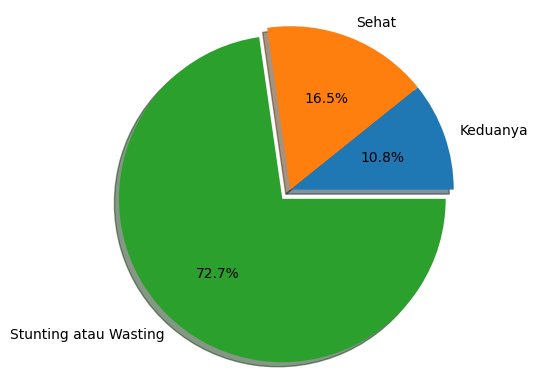

In [17]:
# Visualisasikan Data Keduanya, Sehat, dan Pengidap salah satu penyakit
dataKeduanya = transform_latih.loc[transform_latih.statusKeduanya == 1, 'statusKeduanya'].count()
dataSehat = transform_latih.loc[transform_latih.statusSehat == 1, 'statusSehat'].count()
dataPengidap = transform_latih.jenisKelamin.count() - (dataKeduanya + dataSehat)

data = [dataKeduanya, dataSehat, dataPengidap]
labels = ['Keduanya', 'Sehat', 'Stunting atau Wasting']
explode = [0.0, 0.0, 0.075]

fig1, ax1 = plt.subplots()
ax1.pie(data, explode = explode, shadow = True, autopct = '%.1f%%', labels = labels)
ax1.axis('equal')

plt.show()

In [18]:
# Pembuatan kolom statusBalita
transform_latih['statusBalita'] = 'Unknown'

# Menetapkan nilai statusBalita berdasar 4 fitur
for cursor_latih in transform_latih.itertuples():
    if cursor_latih.statusSehat == True:
        transform_latih.loc[transform_latih.index == cursor_latih.Index, 'statusBalita'] = 'Sehat'
    elif cursor_latih.statusKeduanya == True:
        transform_latih.loc[transform_latih.index == cursor_latih.Index, 'statusBalita'] = 'Keduanya'
    elif cursor_latih.statusWasting == True:
        transform_latih.loc[transform_latih.index == cursor_latih.Index, 'statusBalita'] = 'Wasting'
    elif cursor_latih.statusStunting == True:
        transform_latih.loc[transform_latih.index == cursor_latih.Index, 'statusBalita'] = 'Stunting'        

In [19]:
# Buat dataframe baru hotEncoded yang berisi, well, hot-encoded vector
# Seluruh nilai pada hotEncoded harus bernilai Integer untuk memudahkan model network
hotEncoded = pd.get_dummies(transform_latih.statusBalita, dtype=int)

# Tata ulang seluruh kolom pada hotEncoded sesuai dengan label
hotEncoded = hotEncoded[['Stunting', 'Wasting', 'Keduanya', 'Sehat']]
hotEncoded

,Stunting,Wasting,Keduanya,Sehat
0,1,0,0,0
1,0,0,1,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
7568,0,0,0,1
7569,0,0,1,0
7570,1,0,0,0
7571,1,0,0,0


In [20]:
# Menggabungkan dataframe dataset latih dengan hot encoded vector
# Menggunakan axis = 1 untuk menambahkan kolom
transform_latih = pd.concat([transform_latih, hotEncoded], axis = 1)

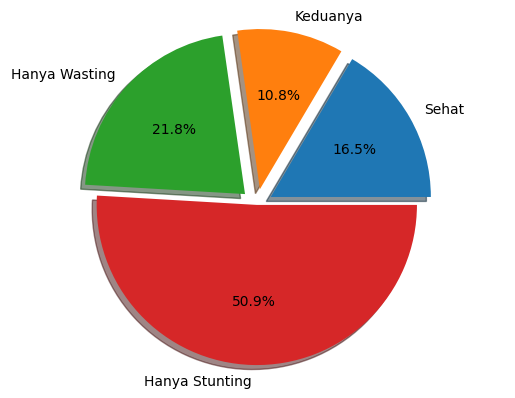

In [21]:
nilaiStunting = hotEncoded.loc[hotEncoded.Stunting == 1, 'Stunting'].count()
nilaiWasting = hotEncoded.loc[hotEncoded.Wasting == 1, 'Wasting'].count()
nilaiKeduanya = hotEncoded.loc[hotEncoded.Keduanya == 1, 'Keduanya'].count()
nilaiSehat = hotEncoded.loc[hotEncoded.Sehat == 1, 'Sehat'].count()

data = [nilaiSehat, nilaiKeduanya, nilaiWasting, nilaiStunting]
explode = [0.1, 0.1, 0.1, 0.0]
labels = ['Sehat', 'Keduanya', 'Hanya Wasting', 'Hanya Stunting']

fig, ax = plt.subplots()

ax.pie(data, explode = explode, labels = labels, autopct = '%1.1f%%', shadow = True)
ax.axis('equal')

plt.show()

In [25]:
# Normalisasi setiap fitur utama numeral
for cursor_latih in transform_latih.itertuples():
    normalisasi_umur = (cursor_latih.umur - transform_latih.umur.min()) / (transform_latih.umur.max() - transform_latih.umur.min())
    normalisasi_beratBadan = (cursor_latih.beratBadan - transform_latih.beratBadan.min()) / (transform_latih.beratBadan.max() - transform_latih.beratBadan.min())
    normalisasi_tinggiBadan = (cursor_latih.tinggiBadan - transform_latih.tinggiBadan.min()) / (transform_latih.tinggiBadan.max() - transform_latih.tinggiBadan.min())
    # Ganti nilai yang ada pada fitur utama dengan nilai normalisasi
    # wajib menggunakan pd.to_numeric untuk menhindari error value
    transform_latih.loc[transform_latih.index == cursor_latih.Index, 'umur'] = pd.to_numeric(normalisasi_umur)
    transform_latih.loc[transform_latih.index == cursor_latih.Index, 'beratBadan'] = pd.to_numeric(normalisasi_beratBadan)
    transform_latih.loc[transform_latih.index == cursor_latih.Index, 'tinggiBadan'] = pd.to_numeric(normalisasi_tinggiBadan)

In [27]:
# Cek data latih
transform_latih.head()

,jenisKelamin,umur,Birth Weight,Birth Length,beratBadan,tinggiBadan,Breastfeeding,Stunting,statusStunting,statusWasting,statusKeduanya,statusSehat,statusBalita,Stunting,Wasting,Keduanya,Sehat
0,0,0.000425,3.0,49,0.070786,0.000054,No,No,1,0,0,0,Stunting,1,0,0,0
1,1,0.004202,2.9,49,0.012917,0.007545,No,Yes,1,1,1,0,Keduanya,0,0,1,0
2,0,0.006396,2.9,49,0.075598,0.008388,No,Yes,1,0,0,0,Stunting,1,0,0,0
3,0,0.012941,2.8,49,0.056146,0.007311,No,Yes,1,0,0,0,Stunting,1,0,0,0
4,0,0.005960,3.1,49,0.094124,0.005672,No,Yes,1,0,0,0,Stunting,1,0,0,0


In [28]:
# Ekspor dataset latih yang sudah diubah
transform_latih.to_csv('./data_latih_transformed.csv')